In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from glob import glob
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

import shutil

# Project
project_common_path = os.path.dirname('.')
project_common_path = os.path.abspath(os.path.join(project_common_path, '..', 'common'))
if not project_common_path in sys.path:
    sys.path.append(project_common_path)

In [3]:
from data_utils import RESOURCES_PATH, GENERATED_DATA, get_annotations
from data_utils import get_id_type_list_from_annotations
from image_utils import generate_label_images
from cv_utils import generate_trainval_kfolds
from xy_providers import DataCache

In [4]:
# ####################################################
#  Transform `sloth` annotations to label images
# ####################################################

sloth_annotations_filename = os.path.join(RESOURCES_PATH, 'cervix_os.json')
annotations = get_annotations(sloth_annotations_filename)
print("Number of hand-made annotations: ", len(annotations))

trainval_id_type_list = get_id_type_list_from_annotations(annotations, select=['os', 'cervix'])
print("Number of cervix/os labels : %i" % len(trainval_id_type_list))

target_files_path = os.path.join(GENERATED_DATA, "trainval_labels_0")
n_target_files = 0
if os.path.exists(target_files_path):
    n_target_files = len(glob(os.path.join(target_files_path, "*.npz")))

if n_target_files != len(trainval_id_type_list):
    print("\n {} - Generated target files".format(datetime.now()))    
    generate_label_images(annotations)
else:
    print("Found %i generated target files" % n_target_files)

('Number of hand-made annotations: ', 4483)
Number of cervix/os labels : 2202
Found 2202 generated target files


In [5]:
print("\n {} - Cross-validation training U-Net model ...".format(datetime.now()))
cache = DataCache(0)


 2017-05-24 01:44:57.935063 - Cross-validation training U-Net model ...


In [6]:
from data_utils import remove_green_imagery
trainval_id_type_list = remove_green_imagery(trainval_id_type_list)

In [7]:
print("Without green imagery: %i" % len(trainval_id_type_list))

Without green imagery: 2184


In [8]:
import numpy as np
from data_utils import compute_type_distribution
compute_type_distribution(np.array(trainval_id_type_list))

[0.25366300366300365, 0.3630952380952381, 0.38324175824175827]

In [15]:
# ####################################################
#  Setup NN parameters
# ####################################################
from unet_keras_v1 import get_unet
from training_utils import segmentation_train as train, segmentation_validate as validate
from data_utils import compute_type_distribution
from training_utils import find_best_weights_file2


def to_set(id_type_array):
    return set([(i[0], i[1]) for i in id_type_array.tolist()])

seed = 54321
optimizer = 'adadelta'
input_shape = (3, 224, 224)

nb_epochs = 30
batch_size = 4
lr_base = 1.0

load_best_weights = False


# ####################################################
#  Start CV
# ####################################################
from training_utils import find_best_weights_file2
from training_utils import exp_decay, step_decay

n_folds = 6
val_fold_index = 0
val_fold_indices = [0, 3, 5,]

for train_id_type_list, val_id_type_list in generate_trainval_kfolds(np.array(trainval_id_type_list), n_folds, seed=seed):
    
    if len(val_fold_indices) > 0:
        if val_fold_index not in val_fold_indices:
            val_fold_index += 1
            continue
        
    save_prefix = 'unet_os_cervix_detector_cvfold=%i_opt=%s_seed=%i' % (val_fold_index, optimizer, seed)
    print("\n\n ---- Validation fold index: ", val_fold_index, "/", n_folds)
    val_fold_index += 1

    print(len(train_id_type_list), len(val_id_type_list))
    assert len(to_set(train_id_type_list) & to_set(val_id_type_list)) == 0, "WTF"
    print(compute_type_distribution(train_id_type_list))
    print(compute_type_distribution(val_id_type_list))

    print("\n {} - Get UNET model ...".format(datetime.now()))
    unet = get_unet(input_shape=input_shape, n_classes=2, optimizer=optimizer)

    if load_best_weights:
        weights_files = glob("weights/%s*.h5" % save_prefix)
        if len(weights_files) > 0:
            best_weights_filename, best_val_loss = find_best_weights_file2(weights_files, field_name='val_loss')
            print("Load best loss weights: ", best_weights_filename, best_val_loss)
            unet.load_weights(best_weights_filename)

    # lrate_decay_f = lambda epoch: step_decay(epoch, lr=lr_base, base=2.0, period=7)
    lrate_decay_f = lambda epoch: exp_decay(epoch, lr=lr_base, a=0.967)
    # lrate_decay_f = None
    
    np.random.seed(seed)
    print("\n {} - Start training ...".format(datetime.now()))
#     h = train(unet,
#               train_id_type_list,
#               val_id_type_list,
#               nb_epochs=nb_epochs,
#               samples_per_epoch=2.0 * len(train_id_type_list),
#               nb_val_samples=len(val_id_type_list),
#               lrate_decay_f=lrate_decay_f,
#               batch_size=batch_size,
#               xy_provider_cache=cache,
#               image_size=input_shape[1:][::-1],
#               seed=seed,              
#               save_prefix=save_prefix)
#     if h is None:
#         continue


Using Theano backend.


Couldn't import dot_parser, loading of dot files will not be possible.


WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GT 750M (CNMeM is enabled with initial size: 50.0% of memory, cuDNN 5110)


('\n\n ---- Validation fold index: ', 0, '/', 6)
(2386, 483)
[0.33654652137468566, 0.33319362950544845, 0.3302598491198659]
[0.30848861283643897, 0.32712215320910976, 0.3643892339544514]

 2017-05-24 01:48:18.881507 - Get UNET model ...

 2017-05-24 01:48:19.638900 - Start training ...
('\n\n ---- Validation fold index: ', 3, '/', 6)
(2389, 483)
[0.3281707827542905, 0.3357053160318125, 0.336123901213897]
[0.34161490683229817, 0.32505175983436857, 0.33333333333333337]

 2017-05-24 01:48:19.906701 - Get UNET model ...

 2017-05-24 01:48:20.838864 - Start training ...
('\n\n ---- Validation fold index: ', 5, '/', 6)
(2393, 483)
[0.3359799414960301, 0.328458002507313, 0.33556205599665695]
[0.3146997929606625, 0.35196687370600416, 0.33333333333333337]

 2017-05-24 01:48:21.083892 - Get UNET model ...

 2017-05-24 01:48:21.838413 - Start training ...


In [16]:
trainval_id_type_list = get_id_type_list_from_annotations(annotations, select=['os', 'cervix', 'ok'])
bad_id_type_list = get_id_type_list_from_annotations(annotations, select=['to_remove', ])
print(len(trainval_id_type_list), len(bad_id_type_list))

## Remove green imagery
from data_utils import remove_green_imagery
trainval_id_type_list = remove_green_imagery(trainval_id_type_list)
print(len(trainval_id_type_list))

(2839, 1644)
2821


In [17]:
from data_utils import test_ids

test_id_type_list = []
for image_id in test_ids:
    test_id_type_list.append((image_id, "Test"))

In [11]:
# ####################################################
#  Crop to cervix/os
# ####################################################

from test_utils import segmentation_predict as predict

batch_size = 8

for val_fold_index in range(n_folds):
    
    save_prefix = 'unet_os_cervix_detector_cvfold=%i_opt=%s_seed=%i' % (val_fold_index, optimizer, seed)
    print("\n {} - Get UNET model ...".format(datetime.now()))
    unet = get_unet(input_shape=input_shape, n_classes=2, optimizer=None)

    weights_files = glob("weights/%s*.h5" % save_prefix)
    if len(weights_files) > 0:
        best_weights_filename, best_val_loss = find_best_weights_file2(weights_files, field_name='val_loss')
        print("Load best loss weights: ", best_weights_filename, best_val_loss)
        unet.load_weights(best_weights_filename)
    else:
        continue
    
    print("\n {} - Start predictions ...".format(datetime.now()))
    predict(unet,
            trainval_id_type_list,
            save_prefix=save_prefix,
            batch_size=batch_size,
            xy_provider_cache=cache,
            image_size=input_shape[1:][::-1])

    predict(unet,
            test_id_type_list,
            save_prefix=save_prefix,
            batch_size=batch_size,
            xy_provider_cache=cache,
            image_size=input_shape[1:][::-1])


 2017-05-24 00:12:40.542659 - Get UNET model ...
('Load best loss weights: ', 'weights/unet_os_cervix_detector_cvfold=0_opt=adadelta_seed=54321_30_val_loss=0.3036_val_jaccard_index=0.6964.h5', 0.3036)

 2017-05-24 00:12:41.708155 - Start predictions ...
Load existing file: /Users/vfomin/Documents/ML/Kaggle/Intel_MobileODT/input/generated/unet_os_cervix_detector_cvfold=0_opt=adadelta_seed=54321_stats.npz
-- 1 / 2821 : 0, Type_1
-- 2 / 2821 : 7, Type_1
-- 3 / 2821 : 10, Type_1
-- 4 / 2821 : 12, Type_1
-- 5 / 2821 : 13, Type_1
-- 6 / 2821 : 14, Type_1
-- 7 / 2821 : 27, Type_1
-- 8 / 2821 : 34, Type_1
-- 9 / 2821 : 35, Type_1
-- 10 / 2821 : 41, Type_1
-- 11 / 2821 : 47, Type_1
-- 12 / 2821 : 48, Type_1
-- 13 / 2821 : 55, Type_1
-- 14 / 2821 : 57, Type_1
-- 15 / 2821 : 81, Type_1
-- 16 / 2821 : 102, Type_1
-- 17 / 2821 : 104, Type_1
-- 18 / 2821 : 109, Type_1
-- 19 / 2821 : 129, Type_1
-- 20 / 2821 : 138, Type_1
-- 21 / 2821 : 139, Type_1
-- 22 / 2821 : 142, Type_1
-- 23 / 2821 : 144, Type

In [18]:
import cv2
import numpy as np

from data_utils import get_filename
from image_utils import imwrite, get_image_data
from postprocessing_utils import os_cervix_postproc, os_cervix_merge_masks, get_bbox

no_os_detected_id_type_list = []
no_cervix_detected_id_type_list = []
image_size = (299, 299)

id_type_list = list(trainval_id_type_list)
id_type_list.extend(test_id_type_list)

l = len(id_type_list)
for i, (image_id, image_type) in enumerate(id_type_list):

    print("-- %i / %i | %s, %s " % (i, l, image_id, image_type))    
    
    filename = get_filename(image_id + '_' + image_type, 'os_cervix_bbox')    
    if os.path.exists(filename):
        continue
    
    os_cervix_masks = []
    for val_fold_index in range(n_folds):    
        save_prefix = 'unet_os_cervix_detector_cvfold=%i_opt=%s_seed=%i' % (val_fold_index, optimizer, seed)
        p = os.path.join(GENERATED_DATA, 'os_cervix_label__%s' % save_prefix)
        if os.path.exists(p):
            os_cervix_masks.append(get_image_data(image_id + "_" + image_type, 'os_cervix_label__%s' % save_prefix))
    
    final_os_cervix_mask = os_cervix_masks[0]
    for mask in os_cervix_masks[1:]:
        final_os_cervix_mask = os_cervix_merge_masks(final_os_cervix_mask, mask)
    final_os_cervix_mask = os_cervix_postproc(final_os_cervix_mask)    
        
    os_cervix = cv2.resize(final_os_cervix_mask, dsize=image_size, interpolation=cv2.INTER_NEAREST)
    cervix_mask = os_cervix[:, :, 1]
    if np.sum(cervix_mask) > 0:
        cervix_bbox = get_bbox(cervix_mask)        
        
        os_mask = os_cervix[:, :, 0]
        if np.sum(os_mask) > 0:
            os_bbox = get_bbox(os_mask)
        else:
            # set cervix instead of os
            print("No os detected on the image: %s, %s" % (image_id, image_type))
            no_os_detected_id_type_list.append((image_id, image_type))
            os_bbox = cervix_bbox

        _image_id = image_id + '_' + image_type
        imwrite(final_os_cervix_mask, _image_id, 'os_cervix_label_final')
        np.savez(filename, os_bbox=os_bbox, cervix_bbox=cervix_bbox, image_size=image_size)
    else:
        print("No cervix detected on the image: %s, %s" % (image_id, image_type))
        no_cervix_detected_id_type_list.append((image_id, image_type))

-- 0 / 3333 | 0, Type_1 
-- 1 / 3333 | 7, Type_1 
-- 2 / 3333 | 10, Type_1 
-- 3 / 3333 | 12, Type_1 
-- 4 / 3333 | 13, Type_1 
-- 5 / 3333 | 14, Type_1 
-- 6 / 3333 | 27, Type_1 
-- 7 / 3333 | 34, Type_1 
-- 8 / 3333 | 35, Type_1 
-- 9 / 3333 | 41, Type_1 
-- 10 / 3333 | 47, Type_1 
-- 11 / 3333 | 48, Type_1 
-- 12 / 3333 | 55, Type_1 
-- 13 / 3333 | 57, Type_1 
-- 14 / 3333 | 81, Type_1 
-- 15 / 3333 | 102, Type_1 
-- 16 / 3333 | 104, Type_1 
-- 17 / 3333 | 109, Type_1 
-- 18 / 3333 | 129, Type_1 
-- 19 / 3333 | 138, Type_1 
-- 20 / 3333 | 139, Type_1 
-- 21 / 3333 | 142, Type_1 
-- 22 / 3333 | 144, Type_1 
-- 23 / 3333 | 148, Type_1 
-- 24 / 3333 | 160, Type_1 
-- 25 / 3333 | 171, Type_1 
-- 26 / 3333 | 176, Type_1 
-- 27 / 3333 | 180, Type_1 
-- 28 / 3333 | 181, Type_1 
-- 29 / 3333 | 191, Type_1 
-- 30 / 3333 | 201, Type_1 
-- 31 / 3333 | 205, Type_1 
-- 32 / 3333 | 208, Type_1 
-- 33 / 3333 | 215, Type_1 
-- 34 / 3333 | 218, Type_1 
-- 35 / 3333 | 229, Type_1 
-- 36 / 3333 | 230,

In [19]:
print(no_cervix_detected_id_type_list)
print(no_os_detected_id_type_list)

[]
[(u'1325', u'Type_2'), (u'595', u'AType_3'), (u'1012', u'AType_3'), (u'1256', u'AType_3'), (u'1675', u'AType_3'), (u'5144', u'AType_3'), (u'6907', u'AType_3'), (u'1953', u'AType_1'), (u'182', u'AType_2'), (u'630', u'AType_2'), ('158', 'Test'), ('502', 'Test')]


### Display some of computed labels

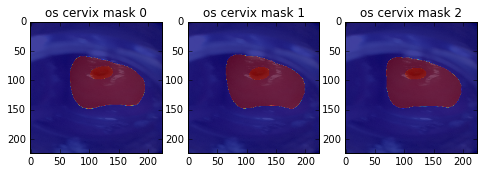

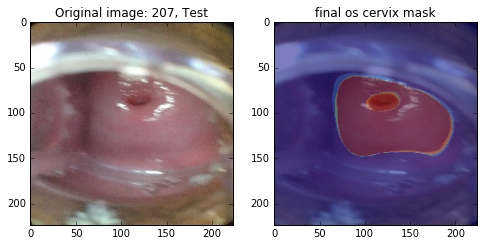

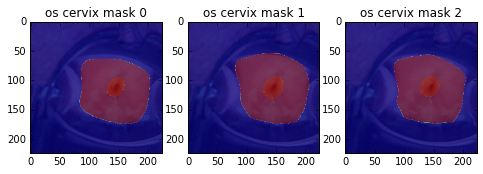

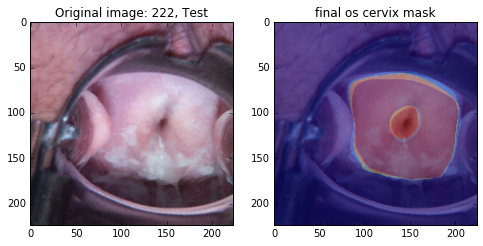

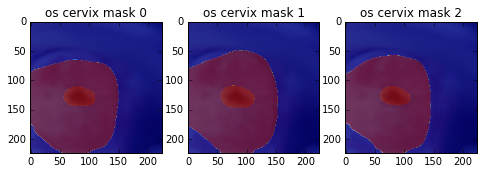

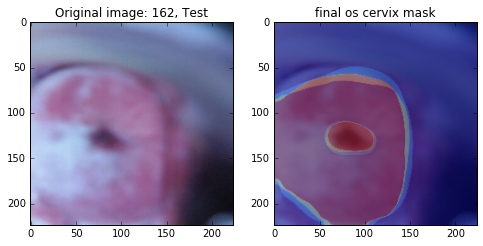

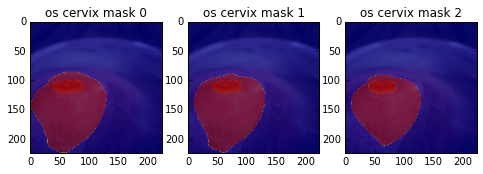

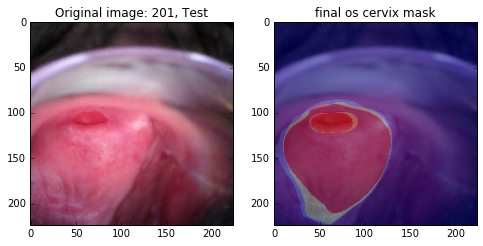

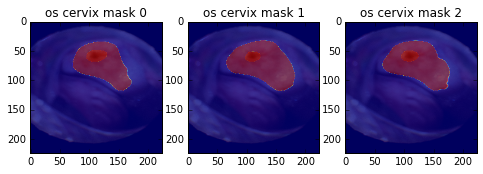

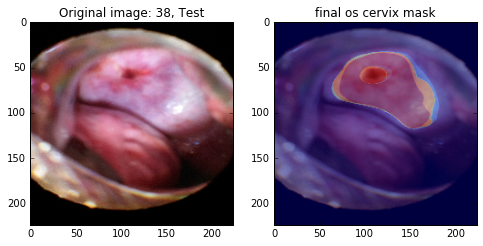

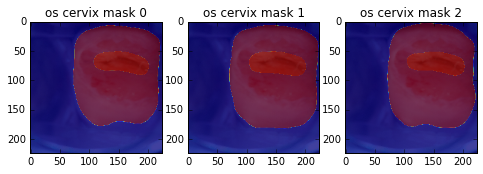

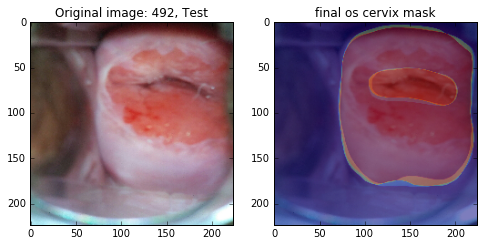

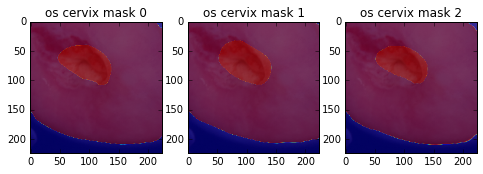

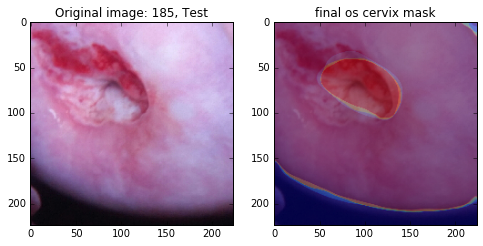

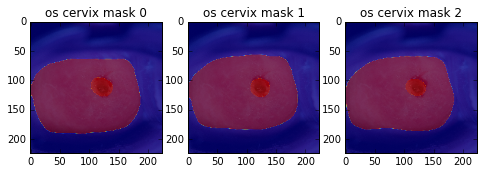

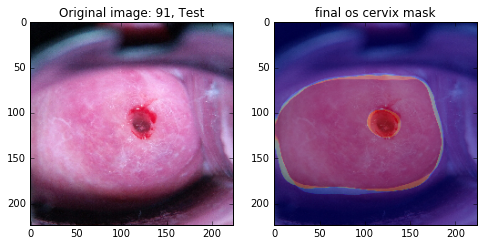

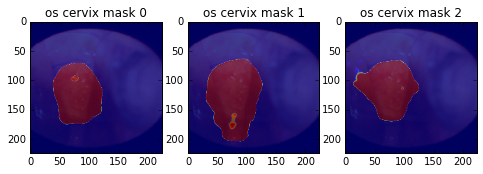

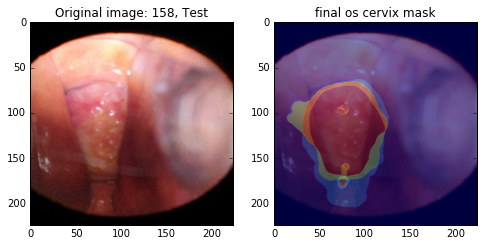

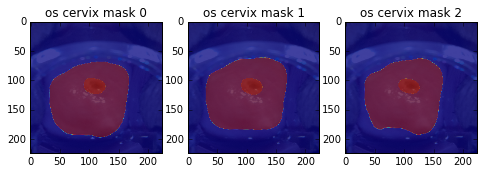

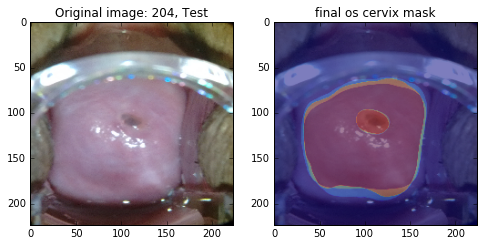

In [16]:
import cv2
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
        
def plt_st(n, m):
    plt.figure(figsize=(n, m))
    
    
from postprocessing_utils import os_cervix_postproc, os_cervix_merge_masks

indices = list(range(len(test_id_type_list)))
id_type_list = np.array(test_id_type_list)[np.random.choice(indices, size=10)]

def _resize(mask, size):
    mask = cv2.resize(mask, dsize=size, interpolation=cv2.INTER_NEAREST)
    return mask


for image_id, image_type in id_type_list:

    img = get_image_data(image_id, image_type)
    
    os_cervix_masks = []
    for val_fold_index in range(n_folds):    
        save_prefix = 'unet_os_cervix_detector_cvfold=%i_opt=%s_seed=%i' % (val_fold_index, optimizer, seed)
        p = os.path.join(GENERATED_DATA, 'os_cervix_label__%s' % save_prefix)
        if os.path.exists(p):
            os_cervix_masks.append(get_image_data(image_id + "_" + image_type, 'os_cervix_label__%s' % save_prefix))
    
    img = _resize(img, os_cervix_masks[0].shape[:2][::-1]) 
    ll = len(os_cervix_masks)
    
    final_os_cervix_mask = os_cervix_masks[0]
    for mask in os_cervix_masks[1:]:
        final_os_cervix_mask = os_cervix_merge_masks(final_os_cervix_mask, mask)
        
    plt_st(8, 4)
    for i in range(ll):
        plt.subplot(1, ll, i+1)
        plt.imshow(img)
        plt.imshow(os_cervix_masks[i][:,:,0], alpha=0.5, cmap='jet')
        plt.imshow(os_cervix_masks[i][:,:,1], alpha=0.5, cmap='jet')
        plt.title("os cervix mask %i" % i)

    plt_st(8, 4)
    plt.subplot(121)
    plt.imshow(img)
    plt.title("Original image: %s, %s" % (image_id, image_type))
    plt.subplot(122)
    plt.imshow(img)
    plt.imshow(final_os_cervix_mask[:,:,0], alpha=0.3, cmap='jet')
    plt.imshow(final_os_cervix_mask[:,:,1], alpha=0.3, cmap='jet')
    plt.title("final os cervix mask")        

## Logs

```
('\n\n ---- Validation fold index: ', 3, '/', 6)
(2006, 420)
[0.30957128614157525, 0.34895314057826515, 0.3414755732801595]
[0.33333333333333337, 0.30000000000000004, 0.3666666666666667]

 2017-05-20 11:57:35.315649 - Get UNET model ...

 2017-05-20 11:57:36.313320 - Start training ...

-- Training parameters: 4, 30, 4016, 424

-- Fit stats of train dataset
2004/2006 [============================>.] - ETA: 0s
-- Fit model
Epoch 1/30
4016/4016 [] - 3156s - loss: 0.5904 - jaccard_index: 0.4096 - recall: 0.8209 - precision: 0.6270 - val_loss: 0.4965 - val_jaccard_index: 0.5035 - val_recall: 0.8509 - val_precision: 0.6931
Epoch 2/30
4016/4016 [] - 2984s - loss: 0.4936 - jaccard_index: 0.5064 - recall: 0.8210 - precision: 0.7268 - val_loss: 0.4517 - val_jaccard_index: 0.5483 - val_recall: 0.8383 - val_precision: 0.7552
Epoch 3/30
4016/4016 [] - 2983s - loss: 0.4515 - jaccard_index: 0.5485 - recall: 0.8335 - precision: 0.7646 - val_loss: 0.4346 - val_jaccard_index: 0.5654 - val_recall: 0.7899 - val_precision: 0.8109
Epoch 4/30
4016/4016 [] - 3014s - loss: 0.4301 - jaccard_index: 0.5699 - recall: 0.8430 - precision: 0.7843 - val_loss: 0.4211 - val_jaccard_index: 0.5789 - val_recall: 0.8553 - val_precision: 0.7789
Epoch 5/30
4016/4016 [] - 3019s - loss: 0.4103 - jaccard_index: 0.5897 - recall: 0.8500 - precision: 0.8022 - val_loss: 0.3899 - val_jaccard_index: 0.6101 - val_recall: 0.9041 - val_precision: 0.7756
Epoch 6/30
4016/4016 [] - 3050s - loss: 0.3929 - jaccard_index: 0.6071 - recall: 0.8562 - precision: 0.8156 - val_loss: 0.3803 - val_jaccard_index: 0.6197 - val_recall: 0.8354 - val_precision: 0.8414
Epoch 7/30
4016/4016 [] - 3008s - loss: 0.3884 - jaccard_index: 0.6116 - recall: 0.8578 - precision: 0.8217 - val_loss: 0.3733 - val_jaccard_index: 0.6267 - val_recall: 0.8789 - val_precision: 0.8052
Epoch 8/30
4016/4016 [] - 2984s - loss: 0.3765 - jaccard_index: 0.6235 - recall: 0.8599 - precision: 0.8293 - val_loss: 0.3665 - val_jaccard_index: 0.6335 - val_recall: 0.8904 - val_precision: 0.8089
Epoch 9/30
4016/4016 [] - 3005s - loss: 0.3729 - jaccard_index: 0.6271 - recall: 0.8628 - precision: 0.8315 - val_loss: 0.3634 - val_jaccard_index: 0.6366 - val_recall: 0.8477 - val_precision: 0.8527
Epoch 10/30
4016/4016 [] - 2983s - loss: 0.3712 - jaccard_index: 0.6288 - recall: 0.8646 - precision: 0.8335 - val_loss: 0.3554 - val_jaccard_index: 0.6446 - val_recall: 0.8689 - val_precision: 0.8416
Epoch 11/30
4016/4016 [] - 2988s - loss: 0.3622 - jaccard_index: 0.6378 - recall: 0.8672 - precision: 0.8384 - val_loss: 0.3533 - val_jaccard_index: 0.6467 - val_recall: 0.8578 - val_precision: 0.8499
Epoch 12/30
4016/4016 [] - 3014s - loss: 0.3596 - jaccard_index: 0.6404 - recall: 0.8692 - precision: 0.8408 - val_loss: 0.3727 - val_jaccard_index: 0.6273 - val_recall: 0.8234 - val_precision: 0.8573
Epoch 13/30
4016/4016 [] - 2982s - loss: 0.3517 - jaccard_index: 0.6483 - recall: 0.8718 - precision: 0.8465 - val_loss: 0.3582 - val_jaccard_index: 0.6418 - val_recall: 0.9002 - val_precision: 0.8101
Epoch 14/30
4016/4016 [] - 2983s - loss: 0.3499 - jaccard_index: 0.6501 - recall: 0.8741 - precision: 0.8470 - val_loss: 0.3505 - val_jaccard_index: 0.6495 - val_recall: 0.8983 - val_precision: 0.8206
Epoch 15/30
4016/4016 [] - 2982s - loss: 0.3447 - jaccard_index: 0.6553 - recall: 0.8759 - precision: 0.8503 - val_loss: 0.3460 - val_jaccard_index: 0.6540 - val_recall: 0.8628 - val_precision: 0.8556
Epoch 16/30
4016/4016 [] - 2987s - loss: 0.3464 - jaccard_index: 0.6536 - recall: 0.8758 - precision: 0.8492 - val_loss: 0.3391 - val_jaccard_index: 0.6609 - val_recall: 0.8709 - val_precision: 0.8495
Epoch 17/30
4016/4016 [] - 2985s - loss: 0.3423 - jaccard_index: 0.6577 - recall: 0.8765 - precision: 0.8517 - val_loss: 0.3433 - val_jaccard_index: 0.6567 - val_recall: 0.8485 - val_precision: 0.8724
Epoch 18/30
4016/4016 [] - 2986s - loss: 0.3401 - jaccard_index: 0.6599 - recall: 0.8778 - precision: 0.8534 - val_loss: 0.3442 - val_jaccard_index: 0.6558 - val_recall: 0.8858 - val_precision: 0.8355
Epoch 19/30
4016/4016 [] - 2984s - loss: 0.3371 - jaccard_index: 0.6629 - recall: 0.8799 - precision: 0.8550 - val_loss: 0.3406 - val_jaccard_index: 0.6594 - val_recall: 0.8770 - val_precision: 0.8551
Epoch 20/30
4016/4016 [] - 2982s - loss: 0.3328 - jaccard_index: 0.6672 - recall: 0.8803 - precision: 0.8568 - val_loss: 0.3437 - val_jaccard_index: 0.6563 - val_recall: 0.8482 - val_precision: 0.8708
Epoch 21/30
4016/4016 [] - 2979s - loss: 0.3318 - jaccard_index: 0.6682 - recall: 0.8807 - precision: 0.8591 - val_loss: 0.3379 - val_jaccard_index: 0.6621 - val_recall: 0.9095 - val_precision: 0.8204
Epoch 22/30
4016/4016 [] - 2979s - loss: 0.3296 - jaccard_index: 0.6704 - recall: 0.8816 - precision: 0.8603 - val_loss: 0.3308 - val_jaccard_index: 0.6692 - val_recall: 0.8505 - val_precision: 0.8802
Epoch 23/30
4016/4016 [] - 2979s - loss: 0.3270 - jaccard_index: 0.6730 - recall: 0.8832 - precision: 0.8619 - val_loss: 0.3258 - val_jaccard_index: 0.6742 - val_recall: 0.8934 - val_precision: 0.8459
Epoch 24/30
4016/4016 [] - 2978s - loss: 0.3279 - jaccard_index: 0.6721 - recall: 0.8821 - precision: 0.8615 - val_loss: 0.3421 - val_jaccard_index: 0.6579 - val_recall: 0.8935 - val_precision: 0.8304
Epoch 25/30
4016/4016 [] - 2979s - loss: 0.3231 - jaccard_index: 0.6769 - recall: 0.8847 - precision: 0.8637 - val_loss: 0.3232 - val_jaccard_index: 0.6768 - val_recall: 0.8915 - val_precision: 0.8500
Epoch 26/30
4016/4016 [] - 2985s - loss: 0.3203 - jaccard_index: 0.6797 - recall: 0.8868 - precision: 0.8641 - val_loss: 0.3288 - val_jaccard_index: 0.6712 - val_recall: 0.9005 - val_precision: 0.8393
Epoch 27/30
4016/4016 [] - 2985s - loss: 0.3213 - jaccard_index: 0.6787 - recall: 0.8856 - precision: 0.8648 - val_loss: 0.3386 - val_jaccard_index: 0.6614 - val_recall: 0.8915 - val_precision: 0.8330
Epoch 28/30
4016/4016 [] - 2985s - loss: 0.3176 - jaccard_index: 0.6824 - recall: 0.8880 - precision: 0.8667 - val_loss: 0.3278 - val_jaccard_index: 0.6722 - val_recall: 0.9021 - val_precision: 0.8417
Epoch 29/30
4016/4016 [] - 2987s - loss: 0.3164 - jaccard_index: 0.6836 - recall: 0.8869 - precision: 0.8671 - val_loss: 0.3224 - val_jaccard_index: 0.6776 - val_recall: 0.8874 - val_precision: 0.8539
Epoch 30/30
4016/4016 [] - 2989s - loss: 0.3157 - jaccard_index: 0.6843 - recall: 0.8869 - precision: 0.8668 - val_loss: 0.3218 - val_jaccard_index: 0.6782 - val_recall: 0.9003 - val_precision: 0.8446

```



----


```

seed = 54321
optimizer = 'adadelta'
input_shape = (3, 224, 224)

nb_epochs = 30
batch_size = 4
lr_base = 1.0

load_best_weights = False

('\n\n ---- Validation fold index: ', 0, '/', 6)
(2009, 420)
[0.320059731209557, 0.3325037332005973, 0.34743653558984566]
[0.29523809523809524, 0.36904761904761907, 0.33571428571428574]

 2017-05-19 02:33:21.800154 - Get UNET model ...

 2017-05-19 02:33:22.769967 - Start training ...

-- Training parameters: 4, 30, 4020, 424

-- Fit stats of train dataset
Load existing file: /Users/vfomin/Documents/ML/Kaggle/Intel_MobileODT/input/generated/unet_os_cervix_detector_cvfold=0_opt=adadelta_seed=54321_stats.npz
No need to recompute statistics

-- Fit model
Epoch 1/30
4020/4020 [] - 3097s - loss: 0.5954 - jaccard_index: 0.4046 - recall: 0.8195 - precision: 0.6237 - val_loss: 0.5135 - val_jaccard_index: 0.4865 - val_recall: 0.8782 - val_precision: 0.6662
Epoch 2/30
4020/4020 [] - 2985s - loss: 0.4957 - jaccard_index: 0.5043 - recall: 0.8219 - precision: 0.7244 - val_loss: 0.4660 - val_jaccard_index: 0.5340 - val_recall: 0.9092 - val_precision: 0.6827
Epoch 3/30
4020/4020 [] - 2985s - loss: 0.4566 - jaccard_index: 0.5434 - recall: 0.8331 - precision: 0.7617 - val_loss: 0.4041 - val_jaccard_index: 0.5959 - val_recall: 0.8906 - val_precision: 0.7594
Epoch 4/30
4020/4020 [] - 2984s - loss: 0.4282 - jaccard_index: 0.5718 - recall: 0.8425 - precision: 0.7880 - val_loss: 0.4017 - val_jaccard_index: 0.5983 - val_recall: 0.8743 - val_precision: 0.7970
Epoch 5/30
4020/4020 [] - 2981s - loss: 0.4103 - jaccard_index: 0.5897 - recall: 0.8511 - precision: 0.8005 - val_loss: 0.3694 - val_jaccard_index: 0.6306 - val_recall: 0.8501 - val_precision: 0.8359
Epoch 6/30
4020/4020 [] - 2981s - loss: 0.4006 - jaccard_index: 0.5994 - recall: 0.8540 - precision: 0.8105 - val_loss: 0.3621 - val_jaccard_index: 0.6379 - val_recall: 0.8350 - val_precision: 0.8651
Epoch 7/30
4020/4020 [] - 2983s - loss: 0.3886 - jaccard_index: 0.6114 - recall: 0.8570 - precision: 0.8195 - val_loss: 0.3655 - val_jaccard_index: 0.6345 - val_recall: 0.8897 - val_precision: 0.8169
Epoch 8/30
4020/4020 [] - 2988s - loss: 0.3825 - jaccard_index: 0.6175 - recall: 0.8606 - precision: 0.8238 - val_loss: 0.3575 - val_jaccard_index: 0.6425 - val_recall: 0.8518 - val_precision: 0.8622
Epoch 9/30
4020/4020 [] - 2985s - loss: 0.3716 - jaccard_index: 0.6284 - recall: 0.8638 - precision: 0.8323 - val_loss: 0.3520 - val_jaccard_index: 0.6480 - val_recall: 0.8697 - val_precision: 0.8527
Epoch 10/30
4020/4020 [] - 2986s - loss: 0.3707 - jaccard_index: 0.6293 - recall: 0.8651 - precision: 0.8353 - val_loss: 0.3423 - val_jaccard_index: 0.6577 - val_recall: 0.8800 - val_precision: 0.8553
Epoch 11/30
4020/4020 [] - 2985s - loss: 0.3675 - jaccard_index: 0.6325 - recall: 0.8678 - precision: 0.8359 - val_loss: 0.3499 - val_jaccard_index: 0.6501 - val_recall: 0.8843 - val_precision: 0.8397
Epoch 12/30
4020/4020 [] - 2981s - loss: 0.3613 - jaccard_index: 0.6387 - recall: 0.8693 - precision: 0.8380 - val_loss: 0.3438 - val_jaccard_index: 0.6562 - val_recall: 0.8834 - val_precision: 0.8394
Epoch 13/30
4020/4020 [] - 2981s - loss: 0.3565 - jaccard_index: 0.6435 - recall: 0.8718 - precision: 0.8423 - val_loss: 0.3462 - val_jaccard_index: 0.6538 - val_recall: 0.8877 - val_precision: 0.8391
Epoch 14/30
4020/4020 [] - 2981s - loss: 0.3545 - jaccard_index: 0.6455 - recall: 0.8725 - precision: 0.8444 - val_loss: 0.3300 - val_jaccard_index: 0.6700 - val_recall: 0.8904 - val_precision: 0.8481
Epoch 15/30
4020/4020 [] - 2981s - loss: 0.3503 - jaccard_index: 0.6497 - recall: 0.8750 - precision: 0.8464 - val_loss: 0.3363 - val_jaccard_index: 0.6637 - val_recall: 0.8920 - val_precision: 0.8448
Epoch 16/30
4020/4020 [] - 2981s - loss: 0.3490 - jaccard_index: 0.6510 - recall: 0.8747 - precision: 0.8474 - val_loss: 0.3207 - val_jaccard_index: 0.6793 - val_recall: 0.8806 - val_precision: 0.8693
Epoch 17/30
4020/4020 [] - 2981s - loss: 0.3466 - jaccard_index: 0.6534 - recall: 0.8767 - precision: 0.8492 - val_loss: 0.3363 - val_jaccard_index: 0.6637 - val_recall: 0.8892 - val_precision: 0.8446
Epoch 18/30
4020/4020 [] - 2981s - loss: 0.3421 - jaccard_index: 0.6579 - recall: 0.8781 - precision: 0.8514 - val_loss: 0.3204 - val_jaccard_index: 0.6796 - val_recall: 0.9027 - val_precision: 0.8479
Epoch 19/30
4020/4020 [] - 2981s - loss: 0.3384 - jaccard_index: 0.6616 - recall: 0.8777 - precision: 0.8544 - val_loss: 0.3380 - val_jaccard_index: 0.6620 - val_recall: 0.8789 - val_precision: 0.8618
Epoch 20/30
4020/4020 [] - 2981s - loss: 0.3364 - jaccard_index: 0.6636 - recall: 0.8794 - precision: 0.8550 - val_loss: 0.3215 - val_jaccard_index: 0.6785 - val_recall: 0.8764 - val_precision: 0.8689
Epoch 21/30
4020/4020 [] - 2980s - loss: 0.3366 - jaccard_index: 0.6634 - recall: 0.8824 - precision: 0.8527 - val_loss: 0.3161 - val_jaccard_index: 0.6839 - val_recall: 0.8912 - val_precision: 0.8608
Epoch 22/30
4020/4020 [] - 2981s - loss: 0.3310 - jaccard_index: 0.6690 - recall: 0.8813 - precision: 0.8580 - val_loss: 0.3249 - val_jaccard_index: 0.6751 - val_recall: 0.8944 - val_precision: 0.8484
Epoch 23/30
4020/4020 [] - 2980s - loss: 0.3327 - jaccard_index: 0.6673 - recall: 0.8822 - precision: 0.8580 - val_loss: 0.3177 - val_jaccard_index: 0.6823 - val_recall: 0.8752 - val_precision: 0.8733
Epoch 24/30
4020/4020 [] - 2987s - loss: 0.3301 - jaccard_index: 0.6699 - recall: 0.8835 - precision: 0.8588 - val_loss: 0.3085 - val_jaccard_index: 0.6915 - val_recall: 0.9000 - val_precision: 0.8619
Epoch 25/30
4020/4020 [] - 2996s - loss: 0.3258 - jaccard_index: 0.6742 - recall: 0.8849 - precision: 0.8621 - val_loss: 0.3088 - val_jaccard_index: 0.6912 - val_recall: 0.8918 - val_precision: 0.8737
Epoch 26/30
4020/4020 [] - 2991s - loss: 0.3258 - jaccard_index: 0.6742 - recall: 0.8831 - precision: 0.8623 - val_loss: 0.3084 - val_jaccard_index: 0.6916 - val_recall: 0.8804 - val_precision: 0.8763
Epoch 27/30
4020/4020 [] - 2988s - loss: 0.3229 - jaccard_index: 0.6771 - recall: 0.8872 - precision: 0.8629 - val_loss: 0.3039 - val_jaccard_index: 0.6961 - val_recall: 0.8782 - val_precision: 0.8883
Epoch 28/30
4020/4020 [] - 2990s - loss: 0.3203 - jaccard_index: 0.6797 - recall: 0.8873 - precision: 0.8635 - val_loss: 0.3042 - val_jaccard_index: 0.6958 - val_recall: 0.8866 - val_precision: 0.8725
Epoch 29/30
4020/4020 [] - 2987s - loss: 0.3178 - jaccard_index: 0.6822 - recall: 0.8885 - precision: 0.8648 - val_loss: 0.3212 - val_jaccard_index: 0.6788 - val_recall: 0.9099 - val_precision: 0.8451
Epoch 30/30
4020/4020 [] - 2980s - loss: 0.3185 - jaccard_index: 0.6815 - recall: 0.8892 - precision: 0.8646 - val_loss: 0.3036 - val_jaccard_index: 0.6964 - val_recall: 0.8844 - val_precision: 0.8777
```